## **Part 1 - Loading and preparing the data**

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
save_checkpoint_dir = "drive/MyDrive/NTU/EE4483"

In [2]:
# Extract data from zip

import os
import zipfile

local_zip = '/content/drive/MyDrive/NTU/EE4483/tmp/datasets.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [17]:
base_dir = '/tmp/datasets'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir,'test')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cat')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dog')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cat')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dog')

In [6]:
# To see some of the images
train_cat_fnames = os.listdir(train_cats_dir)
print(train_cat_fnames[:10])

train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort()
print(train_dog_fnames[:10])

['cat.1755.jpg', 'cat.9993.jpg', 'cat.4930.jpg', 'cat.2329.jpg', 'cat.5019.jpg', 'cat.2213.jpg', 'cat.3629.jpg', 'cat.3364.jpg', 'cat.5740.jpg', 'cat.467.jpg']
['dog.0.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.10000.jpg', 'dog.10001.jpg', 'dog.10002.jpg', 'dog.10003.jpg', 'dog.10004.jpg', 'dog.10005.jpg', 'dog.10006.jpg']


In [7]:
#Number of images of train and validation cats and dogs


print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))



total training cat images: 10000
total training dog images: 10000
total validation cat images: 2500
total validation dog images: 2500


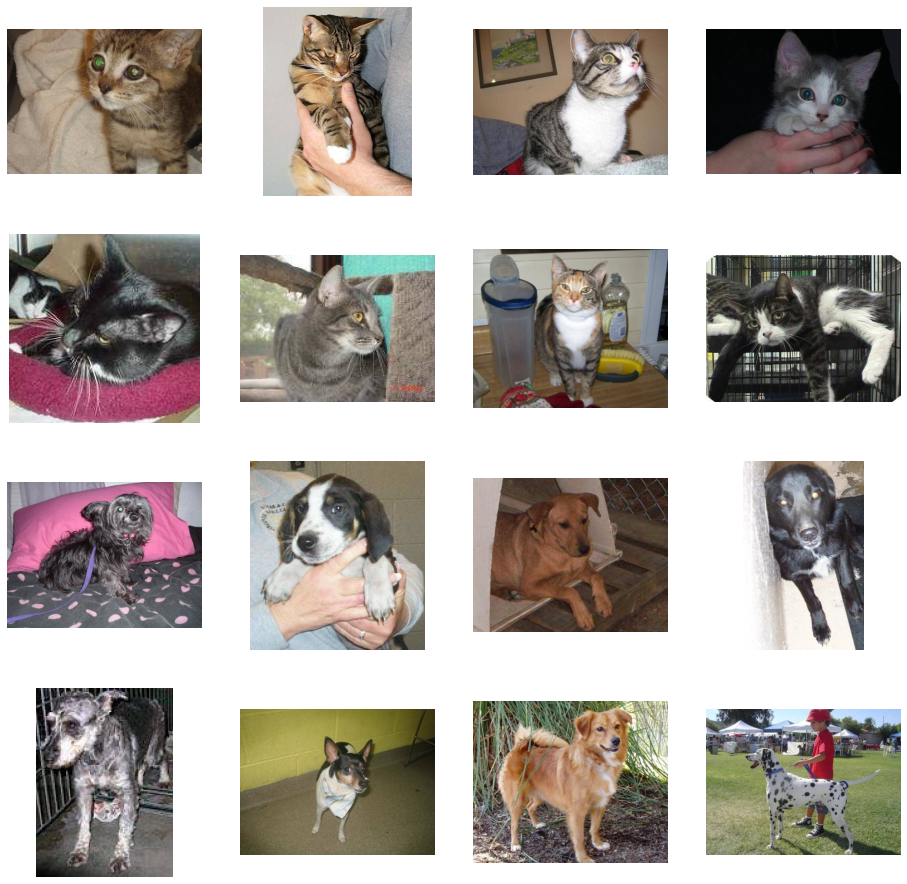

In [8]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

fig = plt.gcf()
fig.set_size_inches(16,16)

pic_index = 0
pic_index += 8
next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[pic_index-8:pic_index]]
next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[pic_index-8:pic_index]]

nrows = 4
ncols = 4
for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

## **Part 2 - Data Augmentation and modelling**

In [8]:
from keras import layers 
from keras import Model 
import tensorflow as tf

In [9]:
#Note that Data augmentation is only use for train set

from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True, validation_split=0.9)

validation_datagen = ImageDataGenerator(rescale = 1./255, validation_split=0.1)

In [10]:
#VGG input is (224,224,3)
# VGG usage is at (224,224)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir, batch_size = 256, class_mode = 'binary', target_size = (224, 224), subset="training" )

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = validation_datagen.flow_from_directory(validation_dir,  batch_size = 256, class_mode = 'binary', target_size = (224, 224), subset="validation")

Found 2000 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [11]:
#Download VGG16 pretrained model and leave the top layer as False so that we can have our own output

from keras.applications.vgg16 import VGG16

base_model = VGG16(input_shape = (224, 224, 3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')

In [12]:
#freeze those layers so that you can train on them
for layer in base_model.layers:
    layer.trainable = False

In [13]:
#Set last layer few layers of output sigmoid as activation layer as it pairs up with binary classification problems Loss function set as binary_crossentropy since its a binary classification problem

# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## **Part 3 - Train Model with VGG16**

In [14]:
model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss = 'binary_crossentropy',metrics = ['acc'])

In [15]:
#Train your model! Remember to add in checkpoints to save the model!
checkpoint_filepath = 'content/drive/MyDrive/NTU/EE4483'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

batch_size=256


vgghist = model.fit(train_generator, validation_data = validation_generator,batch_size=batch_size, epochs = 20, callbacks=[model_checkpoint_callback])

Epoch 1/20
8/8 [==============================] - ETA: 0s - loss: 1.7037 - acc: 0.5480

8/8 [==============================] - 107s 11s/step - loss: 1.7037 - acc: 0.5480 - val_loss: 0.6030 - val_acc: 0.6340
Epoch 2/20
8/8 [==============================] - ETA: 0s - loss: 0.7545 - acc: 0.5870

8/8 [==============================] - 31s 4s/step - loss: 0.7545 - acc: 0.5870 - val_loss: 0.5189 - val_acc: 0.7060
Epoch 3/20
8/8 [==============================] - ETA: 0s - loss: 0.5664 - acc: 0.7050

8/8 [==============================] - 31s 4s/step - loss: 0.5664 - acc: 0.7050 - val_loss: 0.3594 - val_acc: 0.8640
Epoch 4/20
8/8 [==============================] - ETA: 0s - loss: 0.6286 - acc: 0.6885

8/8 [==============================] - 31s 4s/step - loss: 0.6286 - acc: 0.6885 - val_loss: 0.3921 - val_acc: 0.8260
Epoch 5/20
8/8 [==============================] - ETA: 0s - loss: 0.5655 - acc: 0.6965

8/8 [==============================] - 31s 4s/step - loss: 0.5655 - acc: 0.6965 - val_loss: 0.3823 - val_acc: 0.8340
Epoch 6/20
8/8 [==============================] - ETA: 0s - loss: 0.5209 - acc: 0.7290

8/8 [==============================] - 31s 4s/step - loss: 0.5209 - acc: 0.7290 - val_loss: 0.3327 - val_acc: 0.8660
Epoch 7/20
8/8 [==============================] - ETA: 0s - loss: 0.5077 - acc: 0.7335

8/8 [==============================] - 31s 4s/step - loss: 0.5077 - acc: 0.7335 - val_loss: 0.3593 - val_acc: 0.8400
Epoch 8/20
8/8 [==============================] - ETA: 0s - loss: 0.5038 - acc: 0.7660

8/8 [==============================] - 31s 4s/step - loss: 0.5038 - acc: 0.7660 - val_loss: 0.4230 - val_acc: 0.7620
Epoch 9/20
8/8 [==============================] - ETA: 0s - loss: 0.5018 - acc: 0.7500

8/8 [==============================] - 31s 4s/step - loss: 0.5018 - acc: 0.7500 - val_loss: 0.4455 - val_acc: 0.7560
Epoch 10/20
8/8 [==============================] - ETA: 0s - loss: 0.4623 - acc: 0.7715

8/8 [==============================] - 38s 5s/step - loss: 0.4623 - acc: 0.7715 - val_loss: 0.2685 - val_acc: 0.8920
Epoch 11/20
8/8 [==============================] - ETA: 0s - loss: 0.5309 - acc: 0.7705

8/8 [==============================] - 31s 4s/step - loss: 0.5309 - acc: 0.7705 - val_loss: 0.3460 - val_acc: 0.8280
Epoch 12/20
8/8 [==============================] - ETA: 0s - loss: 0.3709 - acc: 0.8400

8/8 [==============================] - 31s 4s/step - loss: 0.3709 - acc: 0.8400 - val_loss: 0.2309 - val_acc: 0.8960
Epoch 13/20
8/8 [==============================] - ETA: 0s - loss: 0.5135 - acc: 0.7605

8/8 [==============================] - 31s 4s/step - loss: 0.5135 - acc: 0.7605 - val_loss: 0.2526 - val_acc: 0.8960
Epoch 14/20
8/8 [==============================] - ETA: 0s - loss: 0.4016 - acc: 0.8090

8/8 [==============================] - 31s 4s/step - loss: 0.4016 - acc: 0.8090 - val_loss: 0.3258 - val_acc: 0.8520
Epoch 15/20
8/8 [==============================] - ETA: 0s - loss: 0.4277 - acc: 0.7920

8/8 [==============================] - 31s 4s/step - loss: 0.4277 - acc: 0.7920 - val_loss: 0.2861 - val_acc: 0.8800
Epoch 16/20
8/8 [==============================] - ETA: 0s - loss: 0.3881 - acc: 0.8180

8/8 [==============================] - 31s 4s/step - loss: 0.3881 - acc: 0.8180 - val_loss: 0.2772 - val_acc: 0.8800
Epoch 17/20
8/8 [==============================] - ETA: 0s - loss: 0.3687 - acc: 0.8325

8/8 [==============================] - 31s 4s/step - loss: 0.3687 - acc: 0.8325 - val_loss: 0.3243 - val_acc: 0.8580
Epoch 18/20
8/8 [==============================] - ETA: 0s - loss: 0.4067 - acc: 0.7995

8/8 [==============================] - 30s 4s/step - loss: 0.4067 - acc: 0.7995 - val_loss: 0.2728 - val_acc: 0.8840
Epoch 19/20
8/8 [==============================] - ETA: 0s - loss: 0.3953 - acc: 0.8200

8/8 [==============================] - 33s 4s/step - loss: 0.3953 - acc: 0.8200 - val_loss: 0.2711 - val_acc: 0.8740
Epoch 20/20
8/8 [==============================] - ETA: 0s - loss: 0.3763 - acc: 0.8185

8/8 [==============================] - 32s 4s/step - loss: 0.3763 - acc: 0.8185 - val_loss: 0.2469 - val_acc: 0.8940


In [16]:
model.save('/content/drive/MyDrive/NTU/EE4483/my_model.h5')

## **Part 4 - Evaluate model**

Text(0.5, 1.0, 'Training and validation loss')

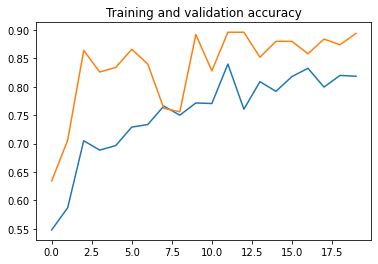

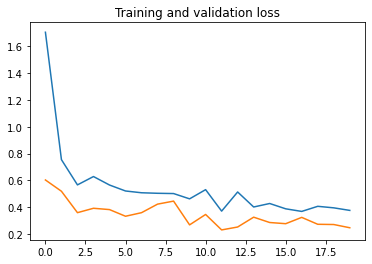

In [17]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = vgghist.history['acc']
val_acc = vgghist.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = vgghist.history['loss']
val_loss = vgghist.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

In [11]:
#Predict with your model!
# Input image filepath and convert it to numpy array for model to predict
from PIL import Image
import numpy as np
from skimage import transform
def load(filename):
   np_image = Image.open(filename)
   np_image = np.array(np_image).astype('float32')/255
   np_image = transform.resize(np_image, (224, 224, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

In [19]:
# Testing your image with VGG model
# Cat: 0 , Dog: 1
test_files = os.listdir(test_dir)
image = load(os.path.join(test_dir,test_files[6])) 

# image 490.jpg is a cat hence output should be 0, try others to test
print(os.path.join(test_dir,test_files[6]))

/tmp/datasets/test/70.jpg


In [20]:
model.predict(image)

1/1 [==============================] - 1s 855ms/step


array([[0.9883199]], dtype=float32)

In [21]:
print(model.predict(image)[0][0])

1/1 [==============================] - 0s 16ms/step
0.9883199


## **Part 5 - Predict test images and parse into submission.csv**

In [9]:
import pandas as pd

In [18]:
from tensorflow import keras
model = keras.models.load_model("/content/drive/MyDrive/NTU/EE4483/my_model.h5")
test_files = os.listdir(test_dir)
testname = []
labels = []
for i in range (1,len(test_files)+1):
  filename = test_dir + "/"+ str(i) + ".jpg"
  imgg= load(filename)

  if model.predict(imgg)[0][0] < 0.5:
    labels.append(0)
    print(0)
    #0 indicate a cat
  else:
    labels.append(1)
    print(1)
    #1 indicate a dog
  testname.append(str(i))

dataframe = pd.DataFrame({"id": testname, "labels": labels}, columns = ["id","labels"])
dataframe.sort_values(by=['id'], ascending=True)
dataframe.to_csv("/content/drive/MyDrive/NTU/EE4483/submissions.csv", index = False)

1/1 [==============================] - 0s 156ms/step
0
1/1 [==============================] - 0s 21ms/step
0
1/1 [==============================] - 0s 24ms/step
0
1/1 [==============================] - 0s 22ms/step
1
1/1 [==============================] - 0s 21ms/step
1
1/1 [==============================] - 0s 21ms/step
0
1/1 [==============================] - 0s 21ms/step
1
1/1 [==============================] - 0s 21ms/step
1
1/1 [==============================] - 0s 23ms/step
1
1/1 [==============================] - 0s 23ms/step
1
1/1 [==============================] - 0s 26ms/step
1
1/1 [==============================] - 0s 24ms/step
0
1/1 [==============================] - 0s 52ms/step
0
1/1 [==============================] - 0s 56ms/step
1
1/1 [==============================] - 0s 87ms/step
1
1/1 [==============================] - 0s 83ms/step
1
1/1 [==============================] - 0s 77ms/step
1
1/1 [==============================] - 0s 40ms/step
0
1/1 [======================

## **Part 6 - CIFAR-10 Datasets**

In [1]:
import tensorflow as tf
from keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#Load the dataset
(X_train, y_train), (X_test,y_test) = datasets.cifar10.load_data()
X_train.shape

170498071/170498071 [==============================] - 16s 0us/step


(50000, 32, 32, 3)

In [3]:
X_test.shape
# Here we see there are 50000 training images and 1000 test images

(10000, 32, 32, 3)

In [4]:
y_train.shape

(50000, 1)

In [5]:
y_train[:5]

# y_train is a 2D array, for our classification having 1D array is good enough. so we will convert this to now 1D array

array([[6],
       [9],
       [9],
       [4],
       [1]], dtype=uint8)

In [6]:
y_train = y_train.reshape(-1,)
y_train[:5]

array([6, 9, 9, 4, 1], dtype=uint8)

In [7]:
y_test = y_test.reshape(-1,)

In [8]:
classes = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

In [9]:
def plot_sample(X, y, index):
    plt.figure(figsize = (15,2))
    plt.imshow(X[index])
    plt.xlabel(classes[y[index]])

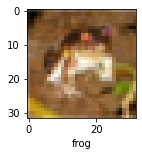

In [10]:
plot_sample(X_train, y_train, 0)

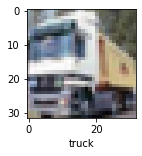

In [11]:
plot_sample(X_train, y_train, 1)


Normalize the images to a number from 0 to 1. Image has 3 channels (R,G,B) and each value in the channel can range from 0 to 255. Hence to normalize in 0-->1 range, we need to divide it by 255

In [12]:
# Normalizing the training data
X_train = X_train / 255.0
X_test = X_test / 255.0

In [13]:
# Build simple artificial neural network for image classification
# softmax normalise the output
ann = models.Sequential([
        layers.Flatten(input_shape=(32,32,3)),
        layers.Dense(3000, activation='relu'),
        layers.Dense(1000, activation='relu'),
        layers.Dense(10, activation='softmax')    
    ])

ann.compile(optimizer='SGD',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

ann.fit(X_train, y_train, epochs=5)

Epoch 1/5
1563/1563 [==============================] - 8s 3ms/step - loss: 1.8102 - accuracy: 0.3567
Epoch 2/5
1563/1563 [==============================] - 5s 3ms/step - loss: 1.6240 - accuracy: 0.4278
Epoch 3/5
1563/1563 [==============================] - 5s 3ms/step - loss: 1.5389 - accuracy: 0.4565
Epoch 4/5
1563/1563 [==============================] - 5s 3ms/step - loss: 1.4799 - accuracy: 0.4797
Epoch 5/5
1563/1563 [==============================] - 6s 4ms/step - loss: 1.4324 - accuracy: 0.4959


In [ ]:
# can see that at the end of 5 epochs, accuracy is at around 49%

In [14]:
from sklearn.metrics import confusion_matrix , classification_report
import numpy as np
y_pred = ann.predict(X_test)
y_pred_classes = [np.argmax(element) for element in y_pred]

print("Classification Report: \n", classification_report(y_test, y_pred_classes))

313/313 [==============================] - 1s 3ms/step
Classification Report: 
               precision    recall  f1-score   support

           0       0.43      0.69      0.53      1000
           1       0.43      0.81      0.56      1000
           2       0.47      0.17      0.24      1000
           3       0.35      0.38      0.36      1000
           4       0.40      0.52      0.45      1000
           5       0.55      0.18      0.27      1000
           6       0.50      0.54      0.52      1000
           7       0.59      0.48      0.53      1000
           8       0.58      0.58      0.58      1000
           9       0.62      0.32      0.42      1000

    accuracy                           0.47     10000
   macro avg       0.49      0.47      0.45     10000
weighted avg       0.49      0.47      0.45     10000



In [15]:
# Now build a convolutional neural network to train our images
cnn = models.Sequential([
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

In [16]:
cnn.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [20]:
cnn.fit(X_train, y_train, epochs=10)

#With CNN, at the end 10 epochs, accuracy was at around 94% which is a significant improvement over ANN. CNN's are best for image classification and gives superb accuracy. Also computation is much less compared to simple ANN as maxpooling reduces the image dimensions while still preserving the features

Epoch 1/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.2162 - accuracy: 0.9228
Epoch 2/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.2026 - accuracy: 0.9264
Epoch 3/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.1975 - accuracy: 0.9285
Epoch 4/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.1864 - accuracy: 0.9326
Epoch 5/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.1845 - accuracy: 0.9331
Epoch 6/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.1704 - accuracy: 0.9381
Epoch 7/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.1722 - accuracy: 0.9377
Epoch 8/10
1563/1563 [==============================] - 5s 4ms/step - loss: 0.1637 - accuracy: 0.9408
Epoch 9/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.1556 - accuracy: 0.9431
Epoch 10/10
1563/1563 [==============================] - 5s 4ms/step - loss: 0.153

In [21]:
cnn.evaluate(X_test,y_test)

313/313 [==============================] - 1s 3ms/step - loss: 2.2763 - accuracy: 0.6695


[2.276256561279297, 0.6694999933242798]

In [22]:
y_pred = cnn.predict(X_test)
y_pred[:5]

313/313 [==============================] - 1s 2ms/step


array([[1.96497951e-09, 2.07207843e-16, 1.95865766e-07, 5.04614234e-01,
        2.37747133e-09, 4.93965328e-01, 1.41995051e-03, 6.57593802e-09,
        3.15723753e-07, 3.67725100e-10],
       [6.77923828e-10, 1.17090346e-08, 1.16627865e-19, 2.96456077e-19,
        1.29688995e-20, 2.99815562e-27, 6.46731657e-28, 1.90218866e-23,
        1.00000000e+00, 1.20270569e-12],
       [8.31729710e-01, 9.57573801e-02, 1.19549677e-05, 5.66705596e-04,
        2.81734856e-06, 4.72864379e-08, 7.05657532e-09, 7.53472364e-07,
        6.36348426e-02, 8.29571765e-03],
       [1.00000000e+00, 5.73730441e-09, 1.66005765e-09, 1.99468508e-09,
        1.06101857e-18, 3.87003288e-24, 1.61571452e-17, 1.14314530e-11,
        1.46875741e-11, 3.55064950e-10],
       [9.56542246e-13, 1.98662714e-13, 1.12935277e-02, 5.48868811e-05,
        1.46543309e-01, 6.27290619e-09, 8.42108309e-01, 6.62948378e-15,
        1.78586157e-14, 3.29523355e-13]], dtype=float32)

In [23]:
y_classes = [np.argmax(element) for element in y_pred]
y_classes[:5]

[3, 8, 0, 0, 6]

In [24]:
y_test[:5]

array([3, 8, 8, 0, 6], dtype=uint8)

'ship'

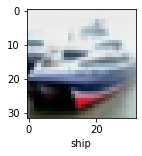

In [29]:
plot_sample(X_test, y_test,1)
classes[y_classes[1]]

'frog'

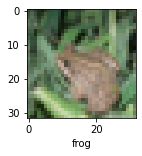

In [32]:
plot_sample(X_test, y_test,4)
classes[y_classes[4]]

'airplane'

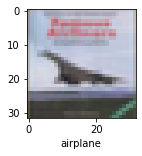

In [30]:
plot_sample(X_test, y_test,3)
classes[y_classes[3]]

## **Clean Up**

In [ ]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)